# Hyperparameter Tuning: Learning Rate and Metrics

Welcome to this first exploration of hyperparameter tuning using the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset!  This dataset consists on 60,000 32x32 color images in 10 classes (6,000 images per class). Here are the classes in the dataset, as well as 10 random images from each: 

![](./nb_image/cifar10.png)

In this notebook, you'll focus specifically on the learning rate, an essential hyperparameter that dictates the pace at which a model learns during training. You'll work with a simple convolutional neural network (CNN) and observe how changes in hyperparameters affect the model's outcomes.

This lab will cover the following:

* Examining the effects of different **learning rates** on model performance.

* Introducing and using additional metrics like **precision, recall, and F1 score** for a more complete evaluation.

* Exploring the effect of **batch size** on different metrics using an imbalanced dataset in an optional section.

## Imports

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics

import helper_utils

helper_utils.set_seed(42)

In [3]:
# # Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Learning Rate Optimization on CIFAR-10

You will now explore how the learning rate affects the performance of a simple convolutional neural network (CNN) on the CIFAR-10 dataset.
For that you will train a simple CNN model with different learning rates and observe the validation accuracy to understand the sensitivity of the model to this hyperparameter.

The code below sets up the necessary functions for training the model and evaluating its performance:

- `SimpleCNN`: defines a small convolutional neural network architecture.

- `evaluate_accuracy`: computes the accuracy on a validation dataset.

These functions encapsulate the key elements required for running the hyperparameter optimization experiments.

In [4]:
class SimpleCNN(nn.Module):
    """A simple Convolutional Neural Network (CNN) architecture.

    This class defines a two-layer CNN with max pooling, dropout, and
    fully connected layers, suitable for basic image classification tasks.
    """
    def __init__(self):
        """Initializes the layers of the neural network."""
        # Initialize the parent nn.Module class
        super(SimpleCNN, self).__init__()
        # First convolutional layer (3 input channels, 16 output channels, 3x3 kernel)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        # Second convolutional layer (16 input channels, 32 output channels, 3x3 kernel)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # Max pooling layer with a 2x2 window and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        # First fully connected (linear) layer
        self.fc1 = nn.Linear(32 * 8 * 8, 64)
        # Second fully connected (linear) layer, serving as the output layer
        self.fc2 = nn.Linear(64, 10)
        # Dropout layer for regularization
        self.dropout = nn.Dropout(p=0.4)
         
    def forward(self, x):
        """Defines the forward pass of the network.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, 3, height, width).

        Returns:
            torch.Tensor: The output logits from the network.
        """
        # Apply first convolution, ReLU activation, and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Apply second convolution, ReLU activation, and max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the feature maps for the fully connected layers
        x = x.view(-1, 32 * 8 * 8)
        # Apply the first fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Apply dropout for regularization
        x = self.dropout(x)
        # Apply the final output layer
        x = self.fc2(x)
        return x


def evaluate_accuracy(model, val_loader, device):
    """Calculates the accuracy of a model on a given dataset.

    Args:
        model (nn.Module): The PyTorch model to be evaluated.
        val_loader (DataLoader): The DataLoader containing the validation or test data.
        device: The device (e.g., 'cuda' or 'cpu') to perform the evaluation on.

    Returns:
        float: The computed accuracy of the model on the dataset.
    """
    # Set the model to evaluation mode
    model.eval()
    # Initialize counters for accuracy calculation
    total_correct = 0
    total_samples = 0

    # Disable gradient computation for evaluation
    with torch.no_grad():
        # Iterate over the data in the provided loader
        for inputs, labels in val_loader:
            # Move input and label tensors to the specified device
            inputs, labels = inputs.to(device), labels.to(device)
            # Perform a forward pass to get model outputs
            outputs = model(inputs)

            # Get the predicted class by finding the index of the maximum logit
            _, predicted = outputs.max(1)
            # Update the count of correctly classified samples
            total_correct += (predicted == labels).sum().item()
            # Update the total number of samples processed
            total_samples += labels.size(0)

    # Calculate the final accuracy
    accuracy = total_correct / total_samples
    # Return the computed accuracy
    return accuracy

In the code below, the `train_and_evaluate` function:

- defines the model  
- sets up the optimizer with a specified learning rate and defines the loss function  
- prepares the train and validation dataloaders  
- trains the model for a specified number of epochs  
- evaluates the model's performance on the validation set

The functions `get_dataset_dataloaders` and `train_model` are imported from `helper_utils` and handle dataset preparation and model training, respectively.

In [5]:
def train_and_evaluate(learning_rate, device, n_epochs=25, batch_size=128):
    """Trains and evaluates a model for a specific learning rate and configuration.

    This function orchestrates the entire workflow: it sets a random seed,
    initializes the model, optimizer, and dataloaders, trains the model,
    and finally evaluates its accuracy on a validation set.

    Args:
        learning_rate (float): The learning rate to use for the optimizer.
        device: The device (e.g., 'cuda' or 'cpu') for training and evaluation.
        n_epochs (int, optional): The number of epochs for training. Defaults to 25.
        batch_size (int, optional): The batch size for the dataloaders. Defaults to 128.

    Returns:
        float: The final validation accuracy of the trained model.
    """
    # Set the random seed for reproducibility
    helper_utils.set_seed(42)

    # Initialize the CNN model and move it to the specified device
    model = SimpleCNN().to(device)

    # Define the loss function
    loss_fcn = nn.CrossEntropyLoss()

    # Define the optimizer with the given learning rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Prepare the training and validation dataloaders
    train_dataloader, val_dataloader = helper_utils.get_dataset_dataloaders(batch_size=batch_size)

    # Call the main training loop to train the model
    helper_utils.train_model(model=model, optimizer=optimizer, loss_fcn=loss_fcn, train_dataloader=train_dataloader, device=device, n_epochs=n_epochs) 

    # Evaluate the trained model's accuracy on the validation set
    accuracy = evaluate_accuracy(model=model, val_loader=val_dataloader, device=device)

    # Print the final results for this configuration
    print(
        f"Learning Rate: {learning_rate}, Accuracy: {accuracy:.4f}"
    )
    # Return the computed accuracy
    return accuracy

A few different learning rates are used from a low ($10^{-5}$) to a high value ($10^{-1}$).

For each learning rate, the model is trained for **25 epochs** with a **batch size of 128**.
After training, the model is evaluated on the validation set to compute the validation accuracy. 

In [6]:
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1] # low to high
accuracies = []

for lr in learning_rates:
    acc = train_and_evaluate(learning_rate=lr, device=device)
    accuracies.append(acc)

100%|██████████| 170M/170M [58:36<00:00, 48.5kB/s]   


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.2604
Epoch 10 - Train Loss: 2.1798
Epoch 15 - Train Loss: 2.1048
Epoch 20 - Train Loss: 2.0460
Epoch 25 - Train Loss: 1.9959
Training complete!

Learning Rate: 1e-05, Accuracy: 0.3240


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.9068
Epoch 10 - Train Loss: 1.6964
Epoch 15 - Train Loss: 1.5813
Epoch 20 - Train Loss: 1.5115
Epoch 25 - Train Loss: 1.4459
Training complete!

Learning Rate: 0.0001, Accuracy: 0.4885


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.5232
Epoch 10 - Train Loss: 1.3653
Epoch 15 - Train Loss: 1.2141
Epoch 20 - Train Loss: 1.1190
Epoch 25 - Train Loss: 1.0013
Training complete!

Learning Rate: 0.001, Accuracy: 0.5855


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.6899
Epoch 10 - Train Loss: 1.5898
Epoch 15 - Train Loss: 1.5328
Epoch 20 - Train Loss: 1.4965
Epoch 25 - Train Loss: 1.4509
Training complete!

Learning Rate: 0.01, Accuracy: 0.4045


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.3090
Epoch 10 - Train Loss: 2.3106
Epoch 15 - Train Loss: 2.3088
Epoch 20 - Train Loss: 2.3106
Epoch 25 - Train Loss: 2.3086
Training complete!

Learning Rate: 0.1, Accuracy: 0.1050


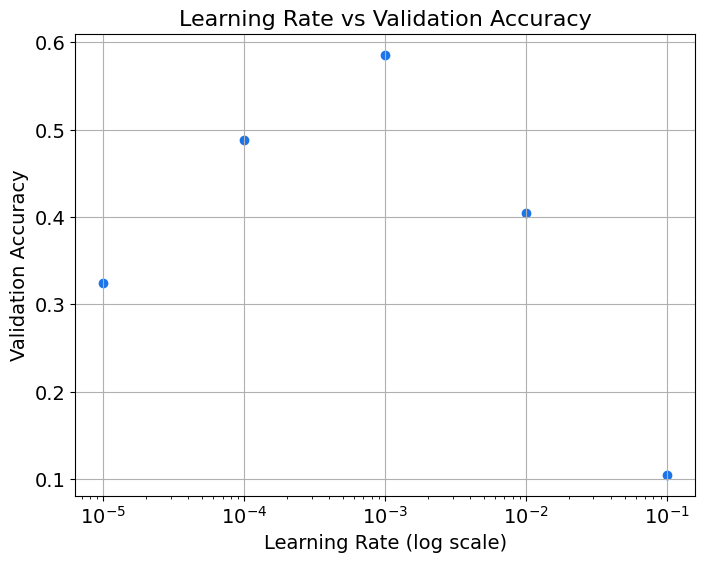

In [7]:
helper_utils.plot_results(learning_rates, accuracies)

<br>

The plot shows that the learning rate of 0.001 provides the highest validation accuracy, indicating it is the **optimal choice** between the tested values.

Smaller learning rates leads to slower learning and lower accuracy, suggesting that the optimizer will take a long time to converge. 
Larger learning rates results in unstable training and lower accuracy.

## Other relevant metrics: Recall, Precision, and F1 Score

Deep learning models are typically trained by optimizing a *loss function*, such as **cross-entropy loss**. 
This loss quantifies the difference between the predicted probabilities and the true labels, guiding the model to adjust its parameters.
It provides a scalar loss that can be minimized using gradient-based optimization algorithms.

However, the loss function optimized during training does not always align with the **evaluation metrics** you care about in practice. Metrics like **accuracy**, **precision**, **recall**, and **F1 score** offer a more nuanced understanding of model performance.

-  **Accuracy**: The ratio of correct predictions to the total number of predictions. 
But it can be misleading in **imbalanced datasets**, where the model may achieve high accuracy simply by predicting the majority class.

- **Precision and Recall**:
These metrics evaluate performance on a **per-class** basis, offering better insight into class-specific behaviors.
For each class $k$:
  $$
  \text{Precision}_k = \frac{\text{TP}_k}{\text{TP}_k + \text{FP}_k}
  $$
  $$
  \text{Recall}_k = \frac{\text{TP}_k}{\text{TP}_k + \text{FN}_k}
  $$

  Where:
  - **TPₖ** (True Positives): Correct predictions for class $k$.
  - **FPₖ** (False Positives): Instances incorrectly predicted as class $k$.
  - **FNₖ** (False Negatives): Instances truly belonging to class $k$ but predicted as another class.
  
  To evaluate overall performance in a multiclass setting, these metrics can be aggregated:

  - **Macro-average**:
    Averages metrics across classes, treating all classes equally.
    *Useful when class balance is important.*
  - **Micro-average**:
    Computes metrics globally by aggregating all TP, FP, and FN.
    *Useful when class sizes vary significantly.*
  - **Weighted-average**:
    Averages metrics across classes, weighted by the number of true instances per class.
    *Balances influence of both major and minor classes.*

- **F1 Score**:
  It combines precision and recall into a single number, useful when both false positives and false negatives are important:
  $$
  \text{F1}_k = 2 \cdot \frac{\text{Precision}_k \cdot \text{Recall}_k}{\text{Precision}_k + \text{Recall}_k}
  $$
  Like precision and recall, it can be aggregated (macro, micro, weighted) depending on the evaluation goal.

All these metrics range from 0 to 1, where higher values indicate better performance. The goal is to maximize each metric.

Some use cases for these metrics include:

- **Precision** is essential when **false positives** are costly (e.g., spam detection, medical diagnosis).
- **Recall** is vital when **false negatives** are costly (e.g., disease screening, fraud detection).
- **F1 score** is ideal when both false positives and false negatives matter, as it provides a trade-off between the two.

## Exercise: Implementing Metrics in PyTorch

The following function `evaluate_metrics` is designed to evaluate a model's performance on a validation dataset using various metrics such as accuracy, precision, recall, and F1 score.

Your exercise is to complete the `evaluate_metrics` function, which calculates key performance metrics for a model using the `torchmetrics` library.

**Your Task**:

* **Initialize the metrics**:
    * In the first code block, create instances for **precision, recall, and F1 score** using the corresponding classes from `torchmetrics`.
    * For each metric, ensure you set the parameters correctly: `task="multiclass"`, `num_classes=num_classes`, and `average="macro"`.
* **Update the metrics in the loop**:
    * Within the second code block, inside the `for` loop, you must update each metric with the results from the current batch.
    * Call the `.update()` method on your `precision_metric`, `recall_metric`, and `f1_metric` objects, passing in the predicted values and the true labels.
* **Compute the final scores**:
    * In the final code block, after the evaluation loop is complete, compute the final value for each metric.
    * Call the `.compute()` method for each metric and then use `.item()` to get the final scalar result to assign to the `precision`, `recall`, and `f1` variables.

In [9]:
def evaluate_metrics(model, val_dataloader, device, num_classes=10):
    """Evaluates the model on a given dataset using multiple metrics.

    Args:
        model (torch.nn.Module): The PyTorch model to be evaluated.
        val_dataloader (DataLoader): The DataLoader containing the validation data.
        device (torch.device): The device (e.g., 'cuda' or 'cpu') to run the evaluation on.
        num_classes (int, optional): The number of classes in the dataset. Defaults to 10.

    Returns:
        tuple: A tuple containing the computed accuracy, precision, recall, and F1 score.
    """
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize accuracy metric
    accuracy_metric = torchmetrics.Accuracy(
        task="multiclass", num_classes=num_classes, average="macro"
    ).to(device)
    
    ### START CODE HERE ###
    
    # Initialize precision metric  using `torchmetrics.Precision`
    precision_metric = torchmetrics.Precision(
        task="multiclass", num_classes=num_classes, average="macro"
    ).to(device)
    
    # Initialize recall metric using `torchmetrics.Recall`
    recall_metric = torchmetrics.Recall(
        task="multiclass", num_classes=num_classes, average="macro"
    ).to(device)
    
    # Initialize F1 score metric using `torchmetrics.F1Score`
    f1_metric = torchmetrics.F1Score(
        task="multiclass", num_classes=num_classes, average="macro"
    ).to(device)
    
    ### END CODE HERE ###

    # Disable gradient computation during evaluation
    with torch.no_grad():
        # Iterate over the validation dataloader
        for inputs, labels in val_dataloader:
            # Move inputs and labels to the specified device
            inputs, labels = inputs.to(device), labels.to(device)
            # Get model predictions
            outputs = model(inputs)
            # Get the predicted class by finding the index of the maximum logit
            _, predicted = torch.max(outputs, 1)

            # Update metrics with the predictions and true labels for the current batch
            accuracy_metric.update(predicted, labels)
            
    ### START CODE HERE ###
            
            # Update `precision_metric` using `.update` method 
            precision_metric.update(predicted, labels)
            
            # Update `recall_metric` using `.update` method
            recall_metric.update(predicted, labels)
            
            # Update `f1_metric` using `.update` method
            f1_metric.update(predicted, labels)
             
    # Compute the final metrics over the entire dataset
    accuracy = accuracy_metric.compute().item()
    
    # Compute precision using `.compute` method and get the value with `.item()`
    precision = precision_metric.compute().item()
    
    # Compute recall using `.compute` method and get the value with `.item()`
    recall = recall_metric.compute().item()
    
    # Compute F1 score using `.compute` method and get the value with `.item()`
    f1 = f1_metric.compute().item()
    
    ### END CODE HERE ###

    return accuracy, precision, recall, f1

<br>

<details>
<summary><span style="color:green;"><strong>Solution (Click here to expand)</strong></span></summary>

```python
def evaluate_metrics(model, val_dataloader, device, num_classes=10):
    """Evaluates the model on a given dataset using multiple metrics.

    Args:
        model (torch.nn.Module): The PyTorch model to be evaluated.
        val_dataloader (DataLoader): The DataLoader containing the validation data.
        device (torch.device): The device (e.g., 'cuda' or 'cpu') to run the evaluation on.
        num_classes (int, optional): The number of classes in the dataset. Defaults to 10.

    Returns:
        tuple: A tuple containing the computed accuracy, precision, recall, and F1 score.
    """
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize accuracy metric
    accuracy_metric = torchmetrics.Accuracy(
        task="multiclass", num_classes=num_classes, average="macro"
    ).to(device)
    
    ### START CODE HERE ###
    
    # Initialize precision metric  using `torchmetrics.Precision`
    precision_metric = torchmetrics.Precision(
        task="multiclass", num_classes=num_classes, average="macro"
    ).to(device)
    
    # Initialize recall metric using `torchmetrics.Recall`
    recall_metric = torchmetrics.Recall(
        task="multiclass", num_classes=num_classes, average="macro"
    ).to(device)
    
    # Initialize F1 score metric using `torchmetrics.F1Score`
    f1_metric = torchmetrics.F1Score(
        task="multiclass", num_classes=num_classes, average="macro"
    ).to(device)
    
    ### END CODE HERE ###

    # Disable gradient computation during evaluation
    with torch.no_grad():
        # Iterate over the validation dataloader
        for inputs, labels in val_dataloader:
            # Move inputs and labels to the specified device
            inputs, labels = inputs.to(device), labels.to(device)
            # Get model predictions
            outputs = model(inputs)
            # Get the predicted class by finding the index of the maximum logit
            _, predicted = torch.max(outputs, 1)

            # Update metrics with the predictions and true labels for the current batch
            accuracy_metric.update(predicted, labels)
            
    ### START CODE HERE ###
            
            # Update `precision_metric` using `.update` method 
            precision_metric.update(predicted, labels)
            
            # Update `recall_metric` using `.update` method
            recall_metric.update(predicted, labels)
            
            # Update `f1_metric` using `.update` method
            f1_metric.update(predicted, labels)
             
    # Compute the final metrics over the entire dataset
    accuracy = accuracy_metric.compute().item()
    
    # Compute precision using `.compute` method and get the value with `.item()`
    precision = precision_metric.compute().item()
    
    # Compute recall using `.compute` method and get the value with `.item()`
    recall = recall_metric.compute().item()
    
    # Compute F1 score using `.compute` method and get the value with `.item()`
    f1 = f1_metric.compute().item()
    
    ### END CODE HERE ###

    return accuracy, precision, recall, f1
```

<br>

In [10]:
# CHECK YOUR IMPLEMENTATION

# model
model = SimpleCNN().to(device)

# dataloaders
train_dataloader, val_dataloader = helper_utils.get_dataset_dataloaders(batch_size=128)

accuracy, precision, recall, f1 = evaluate_metrics(model=model, val_dataloader=val_dataloader, device=device)

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Accuracy: 0.0980, Precision: 0.0179, Recall: 0.0980, F1 Score: 0.0274


#### Expected Output (approximate values):

```
Accuracy: 0.1030, Precision: 0.0103, Recall: 0.1000, F1 Score: 0.0187
```

### How other metrics change with learning rate

*How do these metrics change with different learning rates?*  
To explore this, you will train the model with the same five learning rates and evaluate it using accuracy, precision, recall, and F1 score.

A new `train_and_evaluate_metrics` function is defined to handle the training and evaluation process.

In [11]:
def train_and_evaluate_metrics(learning_rate, device, n_epochs=25, batch_size=128, imbalanced=False):
    """Trains and evaluates a model, returning a comprehensive set of metrics.

    This function orchestrates the end-to-end machine learning pipeline for a
    given configuration. It sets a random seed, initializes the model and
    related components, loads data, runs the training loop, and evaluates
    the model's performance using accuracy, precision, recall, and F1-score.

    Args:
        learning_rate (float): The learning rate for the optimizer.
        device: The device (e.g., 'cuda' or 'cpu') for training and evaluation.
        n_epochs (int, optional): The number of training epochs. Defaults to 25.
        batch_size (int, optional): The batch size for dataloaders. Defaults to 128.
        imbalanced (bool, optional): A flag to use an imbalanced dataset.
                                     Defaults to False.

    Returns:
        tuple: A tuple containing the final validation accuracy, precision,
               recall, and F1-score.
    """
    # Set the random seed for reproducibility
    helper_utils.set_seed(42)

    # Initialize the CNN model and move it to the specified device
    model = SimpleCNN().to(device)

    # Define the loss function for training
    loss_fcn = nn.CrossEntropyLoss()

    # Define the optimizer with the specified learning rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Prepare the training and validation dataloaders
    train_dataloader, val_dataloader = helper_utils.get_dataset_dataloaders(batch_size=batch_size, imbalanced=imbalanced)

    # Call the main training loop to train the model
    helper_utils.train_model(model=model, optimizer=optimizer, loss_fcn=loss_fcn, train_dataloader=train_dataloader, device=device, n_epochs=n_epochs) 

    # Evaluate the trained model to get a full set of performance metrics
    accuracy, precision, recall, f1 = evaluate_metrics(model, val_dataloader, device)

    # Print the final results for this configuration
    print(
        f"Learning Rate: {learning_rate}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}"
    )
    # Return the computed performance metrics
    return accuracy, precision, recall, f1

For each learning rate, the model is trained for **25 epochs** and batch size equals **128**.
After training, the model is evaluated on the validation set to compute accuracy, precision, recall, and F1 score.

Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.2604
Epoch 10 - Train Loss: 2.1798
Epoch 15 - Train Loss: 2.1048
Epoch 20 - Train Loss: 2.0460
Epoch 25 - Train Loss: 1.9959
Training complete!

Learning Rate: 1e-05, Accuracy: 0.3235, Precision: 0.3232, Recall: 0.3235, F1: 0.2850


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.9068
Epoch 10 - Train Loss: 1.6964
Epoch 15 - Train Loss: 1.5813
Epoch 20 - Train Loss: 1.5115
Epoch 25 - Train Loss: 1.4459
Training complete!

Learning Rate: 0.0001, Accuracy: 0.4865, Precision: 0.4849, Recall: 0.4865, F1: 0.4803


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.5232
Epoch 10 - Train Loss: 1.3653
Epoch 15 - Train Loss: 1.2141
Epoch 20 - Train Loss: 1.1190
Epoch 25 - Train Loss: 1.0013
Training complete!

Learning Rate: 0.001, Accuracy: 0.5826, Precision: 0.5892, Recall: 0.5826, F1: 0.5796


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.6899
Epoch 10 - Train Loss: 1.5898
Epoch 15 - Train Loss: 1.5328
Epoch 20 - Train Loss: 1.4965
Epoch 25 - Train Loss: 1.4509
Training complete!

Learning Rate: 0.01, Accuracy: 0.4027, Precision: 0.4136, Recall: 0.4027, F1: 0.3991


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.3090
Epoch 10 - Train Loss: 2.3106
Epoch 15 - Train Loss: 2.3088
Epoch 20 - Train Loss: 2.3106
Epoch 25 - Train Loss: 2.3086
Training complete!

Learning Rate: 0.1, Accuracy: 0.1000, Precision: 0.0105, Recall: 0.1000, F1: 0.0190


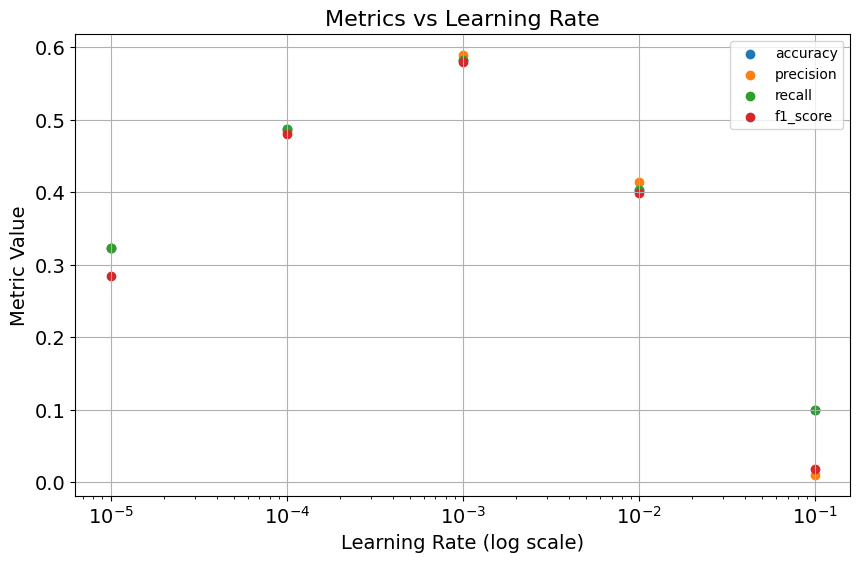

In [12]:
dict_metrics = []

# Loop through different learning rates and collect metrics
for lr in learning_rates:

    # Train and evaluate the model, collecting metrics, for a given learning rate
    n_epochs = 25
    batch_size = 128
    acc, prec, rec, f1 = train_and_evaluate_metrics(learning_rate=lr, device=device, n_epochs=n_epochs, batch_size=batch_size)

    metrics_lr = {
        "learning_rate": lr,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
    }

    dict_metrics.append(metrics_lr)

# Convert the list of dictionaries to a DataFrame for easier plotting
df_metrics = pd.DataFrame(dict_metrics)


helper_utils.plot_metrics_vs_learning_rate(df_metrics)

<br>

In this case, since the dataset is balanced, you can observe that all metrics (accuracy, precision, recall, F1-score) behave similarly for most learning rates, and the value of $10^{-3}$ achieves the best performance across the board.

## (Optional) Further Exploration: Batch Size Optimization on an Imbalanced Dataset

In this section, you'll revisit the previous experiments with the following setup:

- **Learning Rate:** will be set to $10^{−3}$.
- **Imbalanced Dataset:** You'll work with a customized subset of the CIFAR-10 dataset to better observe how metrics are affected by class imbalance.

The new variable you'll explore is **Batch Size**. You will vary its values (32, 64, and 128) to see how these influence different performance metrics.

**Class Imbalanced CIFAR-10 Dataset**
For this experiment, a subset of the CIFAR-10 dataset has been crafted to simulate class imbalance, focusing on three classes: `Cat`, `Dog`, and `Frog`. To mimic a scenario where some classes are more prevalent, the dataset includes all available `Cat` instances, while reducing the number of samples for the other two classes. Specifically, 50% of the original `Dog` images and only 20% of the `Frog` images are retained. As a result, the dataset comprises:

- 6,000 `Cat` images
- 3,000 `Dog` images
- 1,200 `Frog` images
This setup creates a pronounced imbalance, spotlighting the `Cat` class and reflecting real-world situations where certain classes are underrepresented.

In [13]:
# This cell will take about 15 minutes.

dict_metrics = []

# Loop through different batch sizes and collect metrics
batch_sizes = [32, 64, 128]

# Set a fixed learning rate
lr = 0.001  # Medium learning rate

# Set imbalance to True to use imbalanced dataset
imbalanced = True

n_epochs = 25

for bs in batch_sizes:
    acc, prec, rec, f1 = train_and_evaluate_metrics(batch_size=bs, n_epochs=n_epochs, learning_rate=lr, device=device, imbalanced=imbalanced)

    metrics_bs = {
        "batch_size": bs,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
    }
    dict_metrics.append(metrics_bs)

df_metrics = pd.DataFrame(dict_metrics)

FileNotFoundError: [WinError 3] The system cannot find the path specified: './cifar10_3class_imbalanced'

In [ ]:
helper_utils.plot_metrics_vs_batch_size(df_metrics)

<br>

Observe that the optimal batch size depends significantly on the metric being prioritized. **It's common to find that one batch size may optimize a particular metric, while a different batch size yields better results for another**. In conclusion, *a parameter that is optimal for one metric might not be optimal for another*.

## Conclusion

Congratulations on completing this hyperparameter tuning exercise! In this notebook, you explored the impact of varying learning rates on the performance of a CNN trained on the CIFAR-10 dataset. 
By adjusting the learning rate, you observed changes in validation accuracy, and you gained exposure to alternative evaluation metrics like precision, recall, and F1 score. 

Furthermore, you explored the effects of batch size on model performance using an imbalanced subset of the CIFAR-10 dataset.

This experience has deepened your understanding of the significance of learning rate selection in model training and highlighted the utility of comprehensive metrics for evaluating model performance.